# MDI+: Example Usages

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
sys.path.append("../../")

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, roc_auc_score, mean_squared_error
import copy

from imodels.importance import RandomForestPlusRegressor, RandomForestPlusClassifier, \
    RidgeRegressorPPM, LassoRegressorPPM, IdentityTransformer
from imodels.importance.rf_plus import _fast_r2_score

In [47]:
# helper variables
rf_regressor = RandomForestRegressor(n_estimators=20, min_samples_leaf=5, max_features=0.33, random_state=331, n_jobs=1)
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt", random_state=331)

## 1. Regression Example

In [48]:
# generate data from linear model: y = x1 + x2 + N(0, 1)
n = 200
p = 10
s = 2
X = np.random.normal(size=(n, p))
beta = np.concatenate((np.ones(s), np.zeros(p-s)))
y = np.matmul(X, beta) + np.random.normal(size=n)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12345)

### 1.1 Local MDI+ (Feature Contribution) w/ Regression

In [49]:
# fit RF+
rf_plus_model = RandomForestPlusRegressor(rf_model=rf_regressor, include_raw=False)
rf_plus_model.fit(X_train, y_train)

CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS
CALCULATED LOO COEFFICIENTS


In [50]:
# make predictions with RF+
preds = rf_plus_model.predict(X_test)
r2_score(y_test, preds)

0.34199603359194397

In [51]:
# get the subset of the training data to use
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_features=0.33, min_samples_leaf=5, n_estimators=20,
                      n_jobs=1, random_state=331)

In [52]:
n_train = X_train.shape[0]
trainX_subset = shap.utils.sample(X_train, int(.2 * n_train))
        
# fit the KernelSHAP model
shap_model = shap.KernelExplainer(rf_regressor.predict, trainX_subset)
        
# get the SHAP values
shap_values = shap_model.shap_values(X_test)

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been depre

  0%|          | 0/66 [00:00<?, ?it/s]

In [53]:
rf_plus_model.get_shap_scores(X_train, X_test, 0.2)

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
The `ipykernel.comm.Comm` class has been depre

  0%|          | 0/66 [00:00<?, ?it/s]

array([[ 1.37013968e-01,  3.27950576e-01, -3.78342008e-02,
         1.81541227e-03, -8.34127089e-02,  2.57453378e-02,
        -3.35573518e-03,  1.21979880e-02,  1.83966978e-02,
         4.28247929e-02],
       [ 6.08066977e-01, -5.51800768e-01,  2.58079891e-03,
         1.07826205e-02, -2.00008162e-02,  1.36493622e-02,
         7.01516906e-02,  5.04283830e-02, -7.46001069e-03,
         3.42414423e-02],
       [ 5.02426503e-01,  4.77287660e-01,  7.24850930e-02,
         2.86406666e-02,  3.90685960e-02,  7.99487443e-02,
         1.25631033e-02,  3.37941091e-02,  5.13210303e-03,
         5.57063271e-02],
       [ 4.10757958e-01, -5.83143101e-01,  1.29025267e-02,
         5.35688274e-03, -1.33096871e-02, -6.74096708e-02,
        -1.27579998e-03,  1.05119415e-02, -6.45073740e-03,
         4.24425838e-02],
       [-4.29958526e-01,  3.44112372e-01,  3.26852447e-02,
        -1.21403134e-02,  2.81340998e-02,  7.37586544e-02,
         8.54696668e-02,  2.13635850e-02, -5.90943884e-02,
        -4.

In [54]:
rf_regressor.n_estimators

20

#### Leave-One-Out Coefficients: $LFI(i,k)=\sum_{j=1}^p|\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [55]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "inside")

loo coefs: {0: array([[ 0.52714276,  0.58731991,  0.72708859, ..., -0.12148366,
        -0.17553932, -0.10795052],
       [ 0.53106981,  0.58733904,  0.73212297, ..., -0.13543057,
        -0.17518301, -0.1038703 ],
       [ 0.53107956,  0.57556889,  0.73814481, ..., -0.1354495 ,
        -0.17552478, -0.10612218],
       ...,
       [ 0.53104673,  0.58403061,  0.73378285, ..., -0.13538576,
        -0.17554804, -0.1100084 ],
       [ 0.53095104,  0.58712807,  0.73207989, ..., -0.13519992,
        -0.17642846, -0.12927688],
       [ 0.61890894,  0.58748025,  0.70887787, ..., -0.13638066,
        -0.17547536, -0.09946899]])}
loo coefs: {0: array([[ 0.78056075,  0.18304402, -0.1608502 , ..., -0.02779319,
        -0.06161088, -0.10502125],
       [ 0.79665096,  0.18322079, -0.16105544, ...,  0.03058697,
        -0.06174895, -0.09230272],
       [ 0.78564883,  0.2011838 , -0.16079052, ..., -0.02776031,
        -0.06157074, -0.1167074 ],
       ...,
       [ 0.78753284,  0.16568376, -0.1607812

Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.321097  0.604861  0.072782  0.015851  0.081707  0.111074  0.128414   
1    0.494299  0.427900  0.037262  0.047233  0.089027  0.106822  0.076907   
2    0.738662  0.518829  0.044587  0.017321  0.135158  0.139976  0.069871   
3    0.932504  0.531822  0.069292  0.048748  0.054970  0.098122  0.073466   
4    0.499477  0.561764  0.049185  0.083427  0.073617  0.080545  0.087894   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.659212  0.536253  0.034170  0.012367  0.110622  0.087525  0.110463   
130  0.734593  0.459873  0.037204  0.033198  0.068377  0.160951  0.080626   
131  0.519687  0.472779  0.062095  0.042773  0.127465  0.096189  0.095053   
132  0.664716  0.534071  0.057382  0.040675  0.075369  0.115842  0.113491   
133  0.818750  0.561451  0.096936  0.037721  0.097

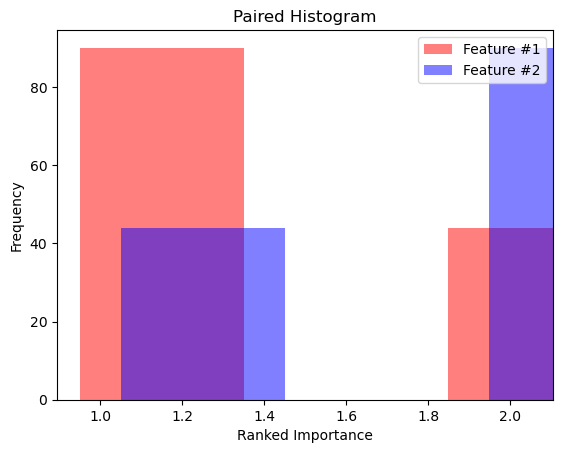

In [56]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value")
print("------------------------------------")
lfi_loo_inner = mdi_plus_scores["lfi"]
print(lfi_loo_inner)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_inner.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Leave-One-Out Coefficients: $LFI(i,k)=|\sum_{j=1}^p\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [57]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "outside")

loo coefs: {0: array([[ 0.52714276,  0.58731991,  0.72708859, ..., -0.12148366,
        -0.17553932, -0.10795052],
       [ 0.53106981,  0.58733904,  0.73212297, ..., -0.13543057,
        -0.17518301, -0.1038703 ],
       [ 0.53107956,  0.57556889,  0.73814481, ..., -0.1354495 ,
        -0.17552478, -0.10612218],
       ...,
       [ 0.53104673,  0.58403061,  0.73378285, ..., -0.13538576,
        -0.17554804, -0.1100084 ],
       [ 0.53095104,  0.58712807,  0.73207989, ..., -0.13519992,
        -0.17642846, -0.12927688],
       [ 0.61890894,  0.58748025,  0.70887787, ..., -0.13638066,
        -0.17547536, -0.09946899]])}
loo coefs: {0: array([[ 0.78056075,  0.18304402, -0.1608502 , ..., -0.02779319,
        -0.06161088, -0.10502125],
       [ 0.79665096,  0.18322079, -0.16105544, ...,  0.03058697,
        -0.06174895, -0.09230272],
       [ 0.78564883,  0.2011838 , -0.16079052, ..., -0.02776031,
        -0.06157074, -0.1167074 ],
       ...,
       [ 0.78753284,  0.16568376, -0.1607812

Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.241274  0.573186  0.071609  0.015174  0.081479  0.086433  0.125286   
1    0.403559  0.379380  0.037222  0.045352  0.087816  0.103057  0.059560   
2    0.673137  0.420778  0.044432  0.016640  0.131890  0.115521  0.063241   
3    0.924745  0.356985  0.058619  0.047384  0.054970  0.095396  0.053057   
4    0.293412  0.524257  0.048012  0.077233  0.073617  0.078165  0.079354   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.620258  0.479130  0.032882  0.011693  0.110403  0.075415  0.109679   
130  0.701044  0.405732  0.037046  0.032414  0.066808  0.157635  0.078990   
131  0.457750  0.390007  0.062055  0.042093  0.124197  0.095007  0.091748   
132  0.382486  0.472238  0.044356  0.039274  0.074792  0.112433  0.107125   
133  0.760008  0.507257  0.096936  0.037575  0.048

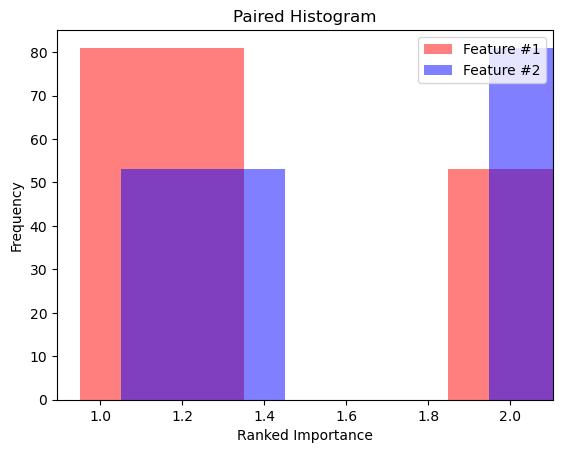

In [58]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_loo_outer = mdi_plus_scores["lfi"]
print(lfi_loo_outer)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_outer.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Leave-One-Out Coefficients: $LFI(i,k)=\sum_{j=1}^p\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}$

In [59]:
# get MDI+ scores (higher r^2 value = greater importance)
Xtraincopy = copy.deepcopy(X_train)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "none")
# check if X_train has been modified
print(np.array_equal(X_train, Xtraincopy))

loo coefs: {0: array([[ 0.52714276,  0.58731991,  0.72708859, ..., -0.12148366,
        -0.17553932, -0.10795052],
       [ 0.53106981,  0.58733904,  0.73212297, ..., -0.13543057,
        -0.17518301, -0.1038703 ],
       [ 0.53107956,  0.57556889,  0.73814481, ..., -0.1354495 ,
        -0.17552478, -0.10612218],
       ...,
       [ 0.53104673,  0.58403061,  0.73378285, ..., -0.13538576,
        -0.17554804, -0.1100084 ],
       [ 0.53095104,  0.58712807,  0.73207989, ..., -0.13519992,
        -0.17642846, -0.12927688],
       [ 0.61890894,  0.58748025,  0.70887787, ..., -0.13638066,
        -0.17547536, -0.09946899]])}
loo coefs: {0: array([[ 0.78056075,  0.18304402, -0.1608502 , ..., -0.02779319,
        -0.06161088, -0.10502125],
       [ 0.79665096,  0.18322079, -0.16105544, ...,  0.03058697,
        -0.06174895, -0.09230272],
       [ 0.78564883,  0.2011838 , -0.16079052, ..., -0.02776031,
        -0.06157074, -0.1167074 ],
       ...,
       [ 0.78753284,  0.16568376, -0.1607812

In [60]:
# get MDI+ scores (higher r^2 value = greater importance)
Xtestcopy = copy.deepcopy(X_test)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_test, y_test, lfi=True,
                                                    lfi_abs = "none", train_or_test = "test",
                                                    sample_split = None)
# check if X_test has been modified
print(np.array_equal(X_test, Xtestcopy))

in this case!
loo coefs: {0: array([[ 0.52714276,  0.58731991,  0.72708859, ..., -0.12148366,
        -0.17553932, -0.10795052],
       [ 0.53106981,  0.58733904,  0.73212297, ..., -0.13543057,
        -0.17518301, -0.1038703 ],
       [ 0.53107956,  0.57556889,  0.73814481, ..., -0.1354495 ,
        -0.17552478, -0.10612218],
       ...,
       [ 0.53104673,  0.58403061,  0.73378285, ..., -0.13538576,
        -0.17554804, -0.1100084 ],
       [ 0.53095104,  0.58712807,  0.73207989, ..., -0.13519992,
        -0.17642846, -0.12927688],
       [ 0.61890894,  0.58748025,  0.70887787, ..., -0.13638066,
        -0.17547536, -0.09946899]])}
in this case!
loo coefs: {0: array([[ 0.78056075,  0.18304402, -0.1608502 , ..., -0.02779319,
        -0.06161088, -0.10502125],
       [ 0.79665096,  0.18322079, -0.16105544, ...,  0.03058697,
        -0.06174895, -0.09230272],
       [ 0.78564883,  0.2011838 , -0.16079052, ..., -0.02776031,
        -0.06157074, -0.1167074 ],
       ...,
       [ 0.78753

Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value
------------------------------------
           0         1         2         3         4         5         6  \
0  -0.122777  0.408336 -0.032130 -0.002835 -0.118364  0.082694  0.065195   
1   0.283056 -0.428125  0.053581  0.024755  0.053158  0.043293  0.029109   
2   0.192493  0.659312  0.017129  0.028942  0.119208  0.121161 -0.021595   
3   0.183559 -0.420317  0.007128  0.007520  0.024910 -0.101969 -0.036121   
4  -0.654063  0.426712  0.016806 -0.021227  0.083954  0.098982  0.032395   
..       ...       ...       ...       ...       ...       ...       ...   
61  0.636918 -0.451005 -0.040451  0.005403  0.022495 -0.067794 -0.002033   
62 -0.100682 -0.244153  0.007128  0.027098  0.003702 -0.080407  0.016165   
63 -0.559114 -0.159077  0.034353  0.005972  0.033932 -0.002328 -0.056149   
64 -0.685819  0.539605  0.016806 -0.012665 -0.072130 -0.140426  0.001899   
65  0.080400 -0.370478 -0.037336  0.024755  0.117165  0.06391

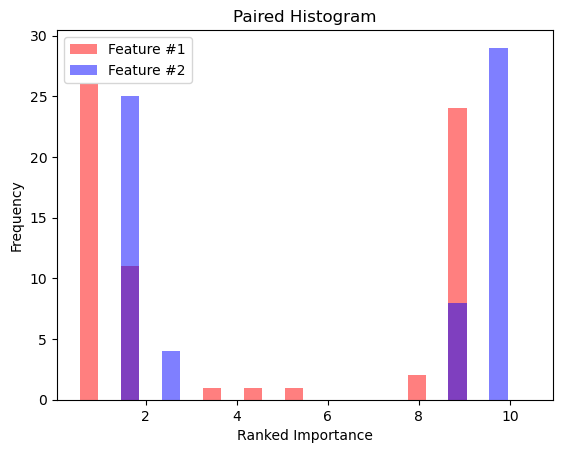

In [61]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_loo_outer = mdi_plus_scores["lfi"]
print(lfi_loo_outer)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_outer.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()